In [2]:
import ray
import numpy as np
import skimage.color
import skvideo.io
import matplotlib.pyplot as plt
import timeit
from threading import Thread
%matplotlib inline

In [3]:
ray.init()

Waiting for redis server at 127.0.0.1:33583 to respond...
Waiting for redis server at 127.0.0.1:57229 to respond...
Starting local scheduler with the following resources: {'GPU': 0, 'CPU': 4}.

View the web UI at http://localhost:8895/notebooks/ray_ui85261.ipynb?token=4efb144c089b6e9f87a4d5159ba1b460cc65ba92eb5079db



{'local_scheduler_socket_names': ['/tmp/scheduler41419959'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store59742155', manager_name='/tmp/plasma_manager31603298', manager_port=52448)],
 'redis_address': '127.0.0.1:33583',
 'webui_url': 'http://localhost:8895/notebooks/ray_ui85261.ipynb?token=4efb144c089b6e9f87a4d5159ba1b460cc65ba92eb5079db'}

In [4]:
@ray.remote
def to_grayscale(rgb_image):
    return skimage.color.rgb2gray(rgb_image)

In [5]:
@ray.remote
class FrameAccumulator:
    def __init__(self):
        self.summed_frames = 0.0
        self.num_frames = 0
        
    def add_frame(self, frame):
        self.summed_frames += frame #skimage.color.rgb2gray(frame)
        self.num_frames += 1
        
    def get_frame(self):
        #if issubclass(self.summed_frames.dtype.type, np.integer):
        #    return np.floor_divide(self.summed_frames, self.num_frames).astype(np.uint8)
        return self.summed_frames / self.num_frames
    
    def get_num_frames(self):
        return self.num_frames

In [25]:
# Decodes the video frame by frame
decoder = skvideo.io.vreader("720p.mov")

In [26]:
# Initialize actors
bw_accumulator = FrameAccumulator.remote()
color_accumulator = FrameAccumulator.remote()

In [27]:
def pipeline_add_frame(i, frame):
    # Convert frame to black and white
    bw_frame = to_grayscale.remote(frame)
    # Add black and white frame to actor
    bw_accumulator.add_frame.remote(bw_frame)
    # Add color frame to actor
    color_accumulator.add_frame.remote(frame)
    # Get average frames from Ray
    avg_frame_ids = [bw_accumulator.get_frame.remote(), color_accumulator.get_frame.remote()]
    bw_frame, color_frame = ray.get(avg_frame_ids)
    filename = "avg_{:03d}.png".format(i)
    if i % 100 == 0:
        bw_thread = Thread(target=plt.imsave, args=("bw_averages/" + filename, np.copy(bw_frame)),
                          kwargs={"cmap": "gray"})
        bw_thread.start()
        color_thread = Thread(target=plt.imsave, args=("color_averages/" + filename,
                                                       np.copy(color_frame)/255))
        color_thread.start()

In [28]:
compute_times = []

In [29]:
for i, frame in enumerate(decoder):
    time = timeit.timeit(lambda : pipeline_add_frame(i, frame), number=1)
    compute_times.append(time)

In [30]:
compute_time = sum(compute_times)
spf = compute_time/len(compute_times)
fps = 1/spf
print("FPS processed = {}".format(fps))
print("Compute time = {}".format(compute_time))

FPS processed = 13.716303885272895
Compute time = 44.69133996500136


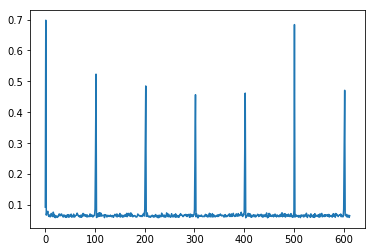

In [37]:
plt.plot(compute_times)

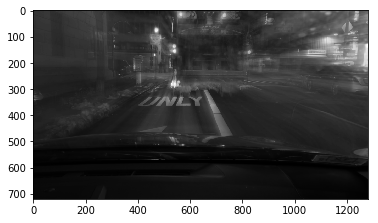

In [32]:
avg_bw_frame = ray.get(bw_accumulator.get_frame.remote())
plt.imshow(avg_bw_frame, cmap="gray")

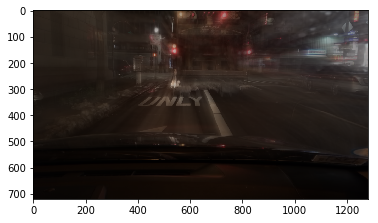

In [34]:
avg_color_frame = ray.get(color_accumulator.get_frame.remote())
plt.imshow(avg_color_frame/255)